In [1]:
from futu import *
import pandas as pd

---

# API鉴权与登录

在终端相应的文件目录下使用命令行运行：

### 端口连接
###### \#注：完成相应查询后，记得执行“ quote_ctx.close() ”命令关闭端口连接，避免条数耗尽

In [ ]:
quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111)

# API函数接口调用

### 期权链条到期日查询
-get_option_expiration_date( code : str )

通过标的股票查询期权链，返回尚未发生行权的期权的所有到期日。<br>
输入的变量是特定港股的股票代码“code”(str)，<br>
返回状态变量“ret”(bool)，有效期权数据“data”(pd.DataFrame)

\# 注：已经过期的期权数据无法通过该API的任何函数查到

In [ ]:
ret, data = quote_ctx.get_option_expiration_date(code='HK.00700')
if ret == RET_OK:
    print(data)
else:
    print('error:', data)
#quote_ctx.close()

### 期权链全链信息查询
-get_option_chain( code :str,  start :str,  end :str,  data_filter :OptionDataFilter )

通过标的股票查询期权链，但是此接口函数仅返回期权链的静态信息，如需获取报价<br>
或摆盘等动态信息，就应该直接使用获取历史K线数据的函数，只需要将输入的代码<br>
改成由此函数或“期权链条到期日”函数返回数据的“期权代码”即可。<br>

输入的变量是特定港股的股票代码“code”(str)，起止日期都为“到期日”(str)，期权属性筛选器(class)<br>
返回状态变量“ret”(bool)，有效期权数据“data”(pd.DataFrame)

\#注：每 30 秒内最多请求 10 次获取期权链接口<br>
\#注：OptionDataFilter类的属性细节参考：<br>
https://openapi.futunn.com/futu-api-doc/quote/get-option-chain.html<br>

In [ ]:
option_valid_ret, option_valid_data = quote_ctx.get_option_expiration_date(code='HK.00700')

filter1 = OptionDataFilter()
filter1.delta_min = 0
filter1.delta_max = 0.1

if option_valid_ret == RET_OK:
    expiration_date_list = option_valid_data['strike_time'].values.tolist()
    for date in expiration_date_list:
        ret, data = quote_ctx.get_option_chain(code  = 'HK.00700', 
                                               start = date, 
                                               end   = date, 
                                               data_filter = filter1)
        if ret == RET_OK:
            print(data)
        else:
            print('error:', data)
        time.sleep(3)
else:
    print('error:', option_valid_data)
#quote_ctx.close()

### 历史K线数据(期权/股票/etc.)
-request_history_kline( code :str, start: str, end :str, fields: list, max_count: int, page_req_key=None )

输入参数：<br>
输入标的物代码“code”(str)如：'HK.00700'、'HK.ALB230530P80000'即可返回相应品种的历史数据<br>
起止日期“start/end”(str)格式如：'2019-01-01'，返回数据的字段“fields”(tuple/list/str)<br>
每次返回的pd.DataFrame的单页最大行数“max_count”(int)，分页请求“page_req_key”(str)<br>
输出内容：<br>
返回一个df，包括code, time_key, OCHL, pe_ratio, turnover_rate, volume, turnover<br>
change_rate(涨跌幅), last_close(昨收价)。

\#注：分钟K线提供最近2年数据，日K及以上提供最近10年的数据；<br>
\#注：每30天内只能获取有限只股票的历史K线数据(当日消耗的历史K线额度，会在30天后自动释放)；<br>
\#注：每30秒内最多请求60次历史K线接口，若是“分页获取数据”则限频规则仅适用于每只股票的首页，后续页请求不受限频规则的限制。

### 股票数据

In [ ]:
# 单页最大数据量为1000,也即返回的pd.DataFrame最多有1000行，需要执行额外操作来得到完整数据
ret, stock_data, page_req_key = quote_ctx.request_history_kline('HK.00700', 
                                                          start='2013-05-25', 
                                                          end='2023-05-25')
if ret == RET_OK:
    print(stock_data)
else:
    print('error:', stock_data)
#quote_ctx.close()

##### 返回单个 pd.DataFrame 数据集

In [7]:
ret, stock_data, page_req_key = quote_ctx.request_history_kline('HK.00700', 
                                                          start='2013-05-25', 
                                                          end='2023-05-25',
                                                          max_count=1000)
if ret == RET_OK:
    data = stock_data
else:
    print('error:', data)
while page_req_key != None:  # 请求后面的所有结果
    print('*************************************')
    ret, stock_data, page_req_key = quote_ctx.request_history_kline('HK.00700', 
                                                                    start='2013-05-25', 
                                                                    end='2023-05-25', 
                                                                    max_count=1000, 
                                                                    page_req_key=page_req_key) # 请求翻页后的数据
    if ret == RET_OK:
        data = pd.concat([data,stock_data],axis=0,ignore_index=True)
    else:
        print('error:', data)
print('All pages are finished!')
#quote_ctx.close()

*************************************
*************************************
All pages are finished!


<AxesSubplot:>

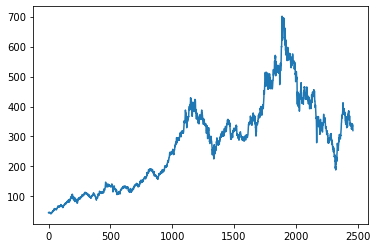

In [8]:
data.close.plot()

### 期权数据

In [ ]:
# 期权数据最早只能追溯到该期权的 “发行日期”
ret, option_data, page_req_key = quote_ctx.request_history_kline('HK.ALB230530P80000', 
                                                          start='2013-05-25', 
                                                          end='2023-05-25')
if ret == RET_OK:
    print(option_data)
else:
    print('error:', option_data)
quote_ctx.close()

### 查看额度
-get_history_kl_quota( get_detail : bool )<br>
-query_subscription( is_all_conn : bool )

In [ ]:
# 历史K线额度查询
ret, data = quote_ctx.get_history_kl_quota(get_detail=True)  # 设置 true 代表需要返回详细的拉取历史 K 线的记录
if ret == RET_OK:
    print(data)
else:
    print('error:', data)

In [ ]:
# 订阅剩余额度查询
quote_ctx.query_subscription(is_all_conn=True)